# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

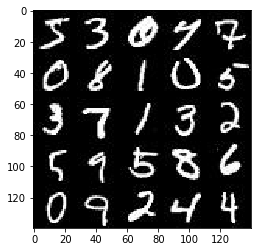

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

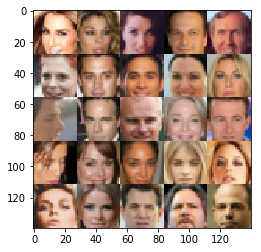

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learn_rate = tf.placeholder(tf.float32, name="learn_rate")
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # First layer - No batch normalization. Images = 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # Now 14x14
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 7x7
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # Now 7x7
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        # Now 4x4
    
        flat = tf.reshape(x4, (-1, 4*4*512))
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse=not is_train):
        # Input layer to fully connected and reshape        
        fc1 = tf.layers.dense(z, 4*4*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)
        
        # Conv layers start here
        x1 = tf.layers.conv2d_transpose(fc1, 256, 4, strides=1, padding="valid", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Now 7x7
    
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 14x14
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Now 14x14
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # Still 14x14
        
        x5 = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Now 28x28
        
        output = tf.nn.tanh(x5)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(inputs_real, inputs_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """        
    # TODO: Implement Function
    g_output = generator(inputs_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(inputs_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)          
    
    smooth = 0.1
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_var = tf.trainable_variables()
    g_var = [var for var in train_var if var.name.startswith("generator")]
    d_var = [var for var in train_var if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #saver = tf.train.Saver()
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
        
    # Build the network
    inputs_real, inputs_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Create random noise inputs for generator. 1 per batch_size for 1:1 ratio
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                    
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                
                # Every 10 steps, print losses
                if steps % 10 == 0:
                    # Every 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images, learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Every 100 steps, print sample images
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)                
        
        #saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 12.0800
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 11.5120
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 19.8219
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 6.5277
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 9.0602
Epoch 1/2... Discriminator Loss: 0.4876... Generator Loss: 3.6447
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 6.3082
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 9.3159
Epoch 1/2... Discriminator Loss: 3.5058... Generator Loss: 19.0689
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 4.0236


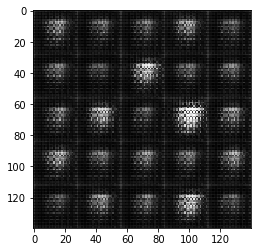

Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 4.3386
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 4.3815
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 4.9711
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 5.2659
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 10.3426
Epoch 1/2... Discriminator Loss: 0.3639... Generator Loss: 4.3658
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 4.5515
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 4.5952
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 5.9678
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 4.0105


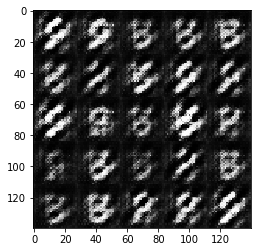

Epoch 1/2... Discriminator Loss: 0.3788... Generator Loss: 4.5151
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 4.7758
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 5.0841
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 5.6378
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 4.6109
Epoch 1/2... Discriminator Loss: 0.4344... Generator Loss: 4.0669
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 3.2722
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 5.3579
Epoch 1/2... Discriminator Loss: 2.4635... Generator Loss: 8.4206
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 3.8675


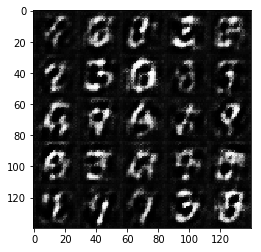

Epoch 1/2... Discriminator Loss: 0.4867... Generator Loss: 4.1531
Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 4.0851
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 3.0445
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 2.8480
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 4.5802
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 4.0305
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 4.4053
Epoch 1/2... Discriminator Loss: 0.4396... Generator Loss: 3.2762
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 3.2590
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 3.7992


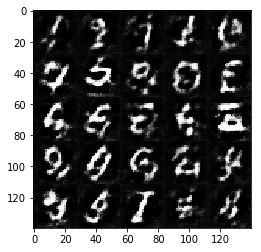

Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 3.5809
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 3.5002
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 3.1344
Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 3.6010
Epoch 1/2... Discriminator Loss: 0.4908... Generator Loss: 3.3802
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 3.3181
Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 3.6983
Epoch 1/2... Discriminator Loss: 0.4874... Generator Loss: 3.3223
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.9245
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 3.7241


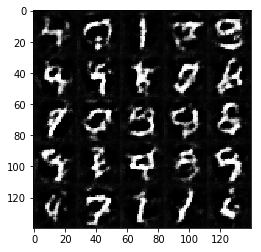

Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 3.2275
Epoch 1/2... Discriminator Loss: 0.4814... Generator Loss: 2.6684
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 4.2166
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 3.2113
Epoch 1/2... Discriminator Loss: 0.4653... Generator Loss: 2.9796
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 3.6999
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 2.7109
Epoch 1/2... Discriminator Loss: 0.5305... Generator Loss: 3.1999
Epoch 1/2... Discriminator Loss: 0.5045... Generator Loss: 3.1095
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 3.4627


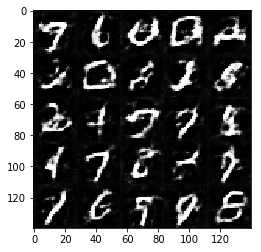

Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.0891
Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 3.6625
Epoch 1/2... Discriminator Loss: 0.6584... Generator Loss: 3.9963
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.6289
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 2.9635
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 2.6556
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 2.7314
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 3.2146
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 3.0982
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 2.0165


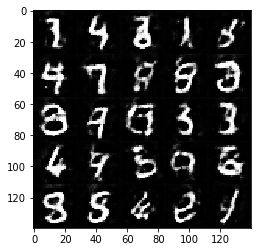

Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 2.9093
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 2.4595
Epoch 1/2... Discriminator Loss: 0.5423... Generator Loss: 2.7293
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 2.8274
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 2.7588
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 3.2273
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 2.8609
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 3.1092
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 3.0294
Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 3.0288


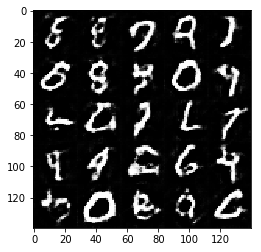

Epoch 1/2... Discriminator Loss: 0.6424... Generator Loss: 3.4010
Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 2.7875
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 2.9249
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 3.3547
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 2.5191
Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 4.3621
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 2.7286
Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 2.5863
Epoch 1/2... Discriminator Loss: 0.4753... Generator Loss: 2.6799
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 2.8149


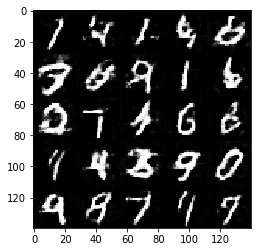

Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 2.6928
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 2.4438
Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 2.9347
Epoch 2/2... Discriminator Loss: 0.4609... Generator Loss: 2.9559
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 2.5641
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 2.7517
Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 2.3855
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 2.8711
Epoch 2/2... Discriminator Loss: 0.5158... Generator Loss: 2.7557
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 2.7042


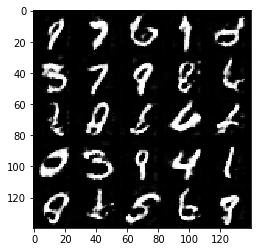

Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 2.6559
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.6310
Epoch 2/2... Discriminator Loss: 0.4959... Generator Loss: 2.9845
Epoch 2/2... Discriminator Loss: 0.4682... Generator Loss: 2.9635
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 2.9632
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 2.7828
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 2.9928
Epoch 2/2... Discriminator Loss: 0.5267... Generator Loss: 3.0722
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 2.9457
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 2.5667


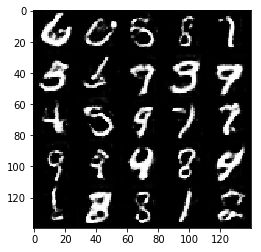

Epoch 2/2... Discriminator Loss: 0.4590... Generator Loss: 2.9582
Epoch 2/2... Discriminator Loss: 0.4677... Generator Loss: 3.1442
Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 3.1002
Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 3.0986
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 3.2427
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 2.8965
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 2.8802
Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 3.1602
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 2.4543
Epoch 2/2... Discriminator Loss: 0.4413... Generator Loss: 2.6721


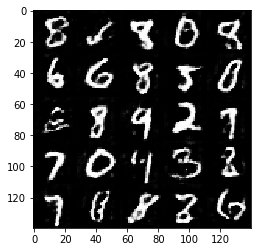

Epoch 2/2... Discriminator Loss: 0.4535... Generator Loss: 2.5798
Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 3.2276
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 3.3165
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 3.0610
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 3.9434
Epoch 2/2... Discriminator Loss: 0.4814... Generator Loss: 2.5300
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 2.9768
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 2.7743
Epoch 2/2... Discriminator Loss: 0.4201... Generator Loss: 2.8767
Epoch 2/2... Discriminator Loss: 0.5340... Generator Loss: 2.9070


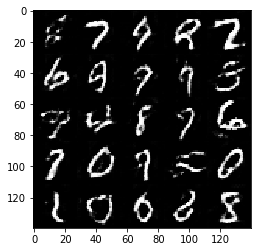

Epoch 2/2... Discriminator Loss: 0.4422... Generator Loss: 2.5962
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 2.6422
Epoch 2/2... Discriminator Loss: 0.4552... Generator Loss: 2.7186
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 2.9762
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 3.5658
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 2.7694
Epoch 2/2... Discriminator Loss: 0.4714... Generator Loss: 2.5537
Epoch 2/2... Discriminator Loss: 0.4651... Generator Loss: 3.0969
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 2.8108
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 3.2937


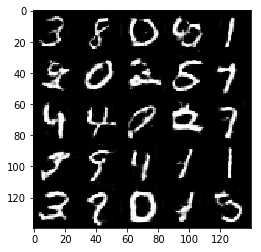

Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 2.7296
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 2.9609
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 3.5201
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 3.1793
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 2.9794
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 2.9468
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 2.4330
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 2.7706
Epoch 2/2... Discriminator Loss: 0.4353... Generator Loss: 2.8030
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 2.7818


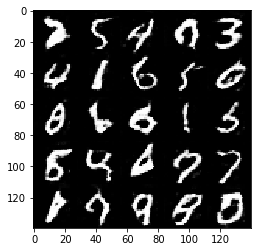

Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.8497
Epoch 2/2... Discriminator Loss: 0.4920... Generator Loss: 2.4903
Epoch 2/2... Discriminator Loss: 0.4849... Generator Loss: 3.1833
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 2.9777
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 3.1080
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 3.3028
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 2.8415
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 2.5742
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 2.9495
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 2.7751


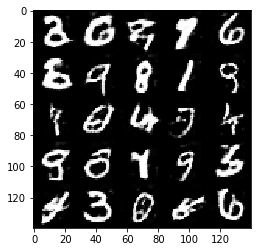

Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 3.2178
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 3.0206
Epoch 2/2... Discriminator Loss: 0.4869... Generator Loss: 3.0590
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 3.3041
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 3.1695
Epoch 2/2... Discriminator Loss: 0.4504... Generator Loss: 2.5705
Epoch 2/2... Discriminator Loss: 0.4813... Generator Loss: 3.1416
Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 3.2787
Epoch 2/2... Discriminator Loss: 0.5366... Generator Loss: 3.1329
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 2.3092


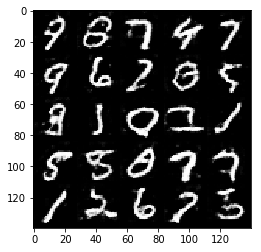

Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 2.2252
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 3.6047
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 3.0918
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 2.6807
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 3.1191
Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 2.5380
Epoch 2/2... Discriminator Loss: 0.4636... Generator Loss: 3.0358
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 2.7641
Epoch 2/2... Discriminator Loss: 0.4162... Generator Loss: 3.1982
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 1.9441


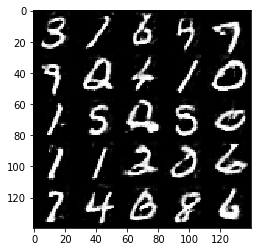

Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.4341
Epoch 2/2... Discriminator Loss: 0.4550... Generator Loss: 2.5195
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 3.3527
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 2.4453
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.7828
Epoch 2/2... Discriminator Loss: 0.4683... Generator Loss: 2.6377
Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 2.3282


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3448... Generator Loss: 26.1593
Epoch 1/1... Discriminator Loss: 1.8941... Generator Loss: 27.0563
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 13.7372
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 8.7821
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 6.4336
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 6.9405
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 5.1563
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 2.1883
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.2802
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 4.6361


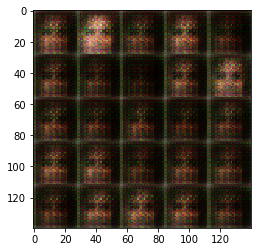

Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.8869
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 7.1740
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 5.0943
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 5.4624
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.8171
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 4.3246
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.5868
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.4384
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.5866
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 2.6668


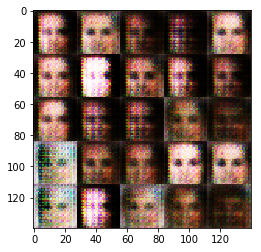

Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 4.3150
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 5.0347
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 4.0040
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 3.1685
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 3.6199
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 3.0021
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.3524
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 4.6099
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 4.6343
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 5.9689


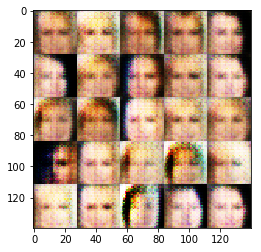

Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 4.4102
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 5.9230
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.3669
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 5.3067
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 3.7979
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 4.8883
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 4.7483
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 4.2768
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.7913
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 4.5848


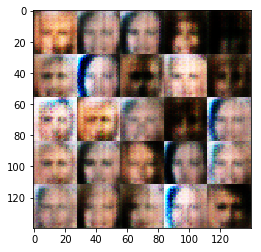

Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 3.9760
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.9181
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.5065
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 3.6937
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 3.5601
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 4.6857
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 4.2659
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 4.5653
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 3.4485
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 3.1038


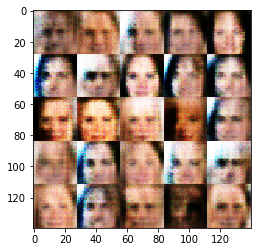

Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 4.3460
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 3.4855
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 3.3489
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 4.2945
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 3.9539
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 7.1380
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 5.3386
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 2.7013
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 2.9144
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 3.1185


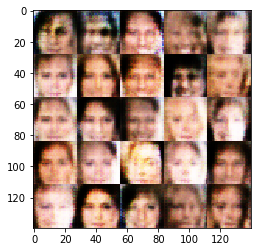

Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.4788
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 5.3062
Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 3.0308
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 4.0176
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 4.1082
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 4.4913
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 3.9626
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 3.3142
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.7178
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 4.5175


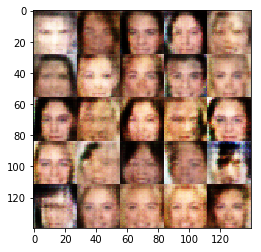

Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 3.2187
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 3.3354
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 4.0105
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 3.5969
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 4.4486
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 6.6702
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 4.9371
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 5.7628
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.1852
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 3.0098


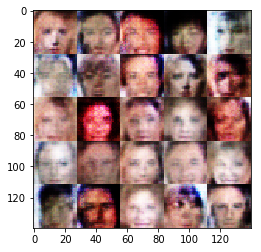

Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 5.2346
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 4.5678
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 4.6395
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 3.2258
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 3.6547
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 3.1562
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 3.4595
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 5.5864
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 4.5581
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 4.9829


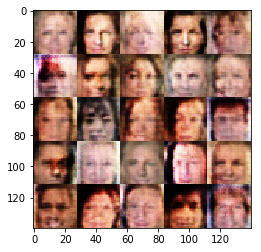

Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.7336
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 2.8954
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 4.7241
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 3.2678
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 4.0957
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 4.2992
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 4.3054
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 3.6950
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 4.5332
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.5116


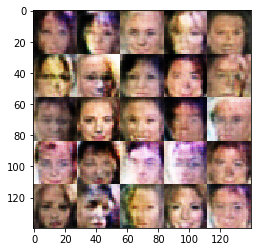

Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.9200
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 4.7953
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 3.9095
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 4.9508
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 3.4796
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 4.0458
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 3.5996
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 3.8313
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 6.7572
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 4.3207


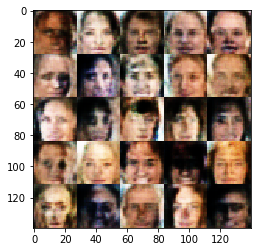

Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 4.1972
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 4.0118
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.6098
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 5.0135
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 5.6927
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 3.9836
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 4.1298
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 3.6723
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.6663
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 4.2343


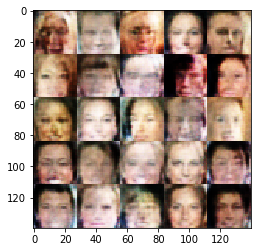

Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 2.5373
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 5.5829
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 4.3027
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.5508
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.4166
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.9601
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 4.1797
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 3.8997
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 5.2151
Epoch 1/1... Discriminator Loss: 1.9872... Generator Loss: 7.0687


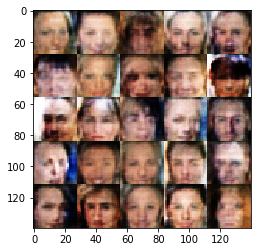

Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 4.4372
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 3.8786
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 4.8036
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.3848
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.3035
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.6095
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 3.8075
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 2.9876
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.6052


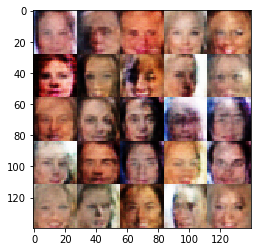

Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 3.8049
Epoch 1/1... Discriminator Loss: 1.9139... Generator Loss: 7.4619
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 3.5721
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.4540
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 3.7700
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 3.9466
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 4.7102
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 3.4265
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 4.2719


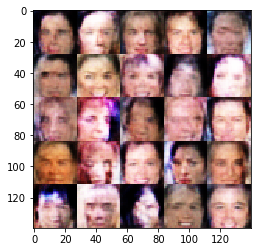

Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.2822
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 4.2538
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 4.2971
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.6618
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 3.9817
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.7919
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.8956
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 4.1141
Epoch 1/1... Discriminator Loss: 3.1323... Generator Loss: 11.3777
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 3.5175


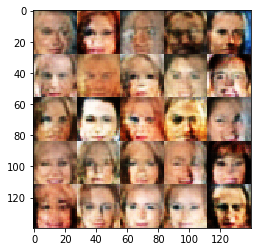

Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.9581
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 3.8834
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 4.1190
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 3.8913
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 5.6367
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.3875
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 4.1172
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 5.2464
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 5.7561
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 3.9473


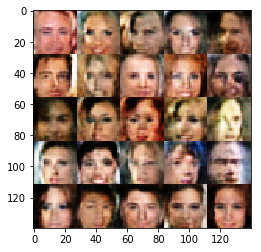

Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.1369
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.2216
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 4.4507
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.3414
Epoch 1/1... Discriminator Loss: 3.1733... Generator Loss: 8.4546
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 3.6472
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 4.2237
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.8511
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 4.3656
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 5.3598


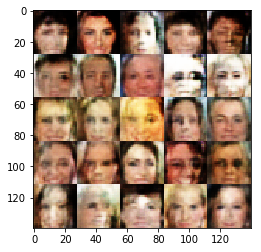

Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.4727
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 4.1152
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 6.2319
Epoch 1/1... Discriminator Loss: 1.8844... Generator Loss: 7.8847
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.1896
Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 4.0822
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 4.3300
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 5.2367
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 4.8523


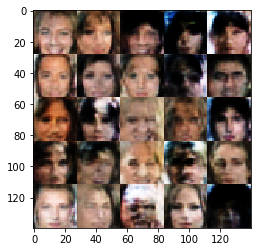

Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 5.5617
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 4.7856
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 5.4978
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 4.9902
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 7.8245
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 5.4212
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 7.5784
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.8720
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 3.6971
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 4.3570


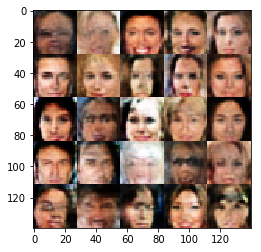

Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 5.4063
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 6.4423
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 3.8704
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 6.5609
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 4.3866
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.0072
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 4.3231
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 5.7091
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 3.8927
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 4.9296


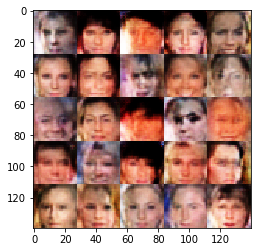

Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.5085
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 3.9172
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 4.5566
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 6.2429
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 4.3524
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.2021
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 4.2250
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.5106
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 4.9068
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.7181


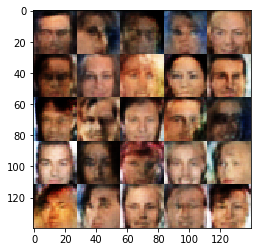

Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 3.9081
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 3.9980
Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 4.7142
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 4.4154
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 4.7300
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.5018
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 4.5739
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 4.4083
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 4.1267
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.8972


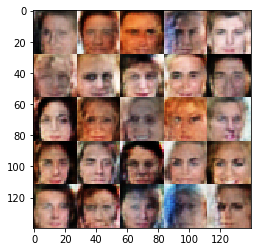

Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 3.6485
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 4.1281
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 4.9406
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.9938
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 4.5151
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 4.9844
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 4.5757
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 3.9018
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 4.1794
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.3804


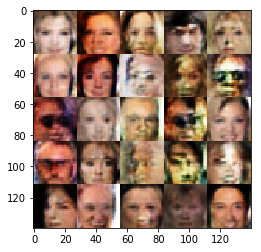

Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 3.9421
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.2367
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.7790
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 5.7076
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 4.4487
Epoch 1/1... Discriminator Loss: 5.0451... Generator Loss: 10.0173
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 4.2698
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 4.0614
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 3.7795
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 4.0968


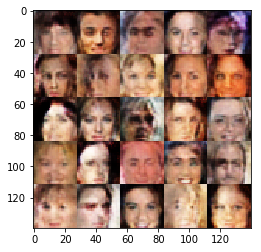

Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 3.9068
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 4.0246
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 4.2677
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 4.4460
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 4.1725
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 4.1779
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 4.2864
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.8566
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 4.3500
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 5.0053


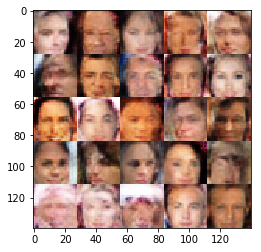

Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 4.2824
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.2174
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 4.3964
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 5.6266
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 4.6282
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 6.8441
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 4.1638
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.8457
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 4.3797
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.1694


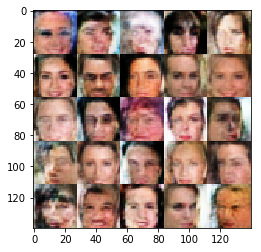

Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 4.3412
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 4.9561
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.8749
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 4.1882
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 4.4560
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 4.3126
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 4.8444
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 8.1392
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 4.2349
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 3.8187


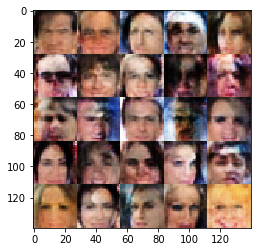

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 7.4993
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.5688
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.3856
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 4.2311
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 4.7978
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 4.9779
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 4.4826
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 3.8051
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 4.1238
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 5.0670


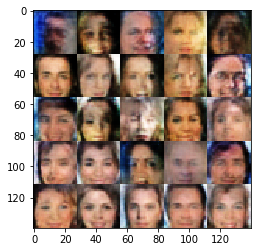

Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.2357
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.0931
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 4.4237
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.6289
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 4.3311
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 4.1254
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 5.0072
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 4.3560
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 5.0539
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.5812


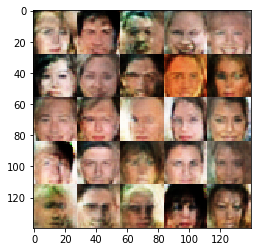

Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 4.3966
Epoch 1/1... Discriminator Loss: 2.2582... Generator Loss: 8.2365
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.5524
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 4.1359
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 5.0518
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 4.7972
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 3.9884
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 4.5689
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 3.7642
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 4.0427


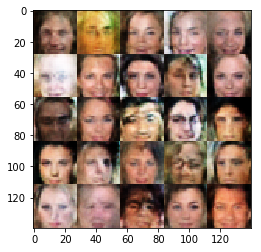

Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 5.4769
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 4.6460
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 3.8228
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 3.9383
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 5.1733
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 5.0794


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.